<a href="https://colab.research.google.com/github/juliakatsoulis/Portfolio/blob/main/Tree_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tree methods & K-Means



## Decision Trees in `sklearn`.

### Here, I am training a  decision tree classifier on a `wine.csv` dataset using `DecisionTreeClassifier` with the dataset split into training and test sets using an 80/20 split. 5-fold cross validation is used to tune `max_depth=[2, 3, 4, 5, 6]` and `min_samples_leaf=[1, 5, 10]`. The best values for these two parameters are reported along with the training and test accuracy.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


best parameters: {'max_depth': 3, 'min_samples_leaf': 1}
training accuracy: 0.9929577464788732
testing accuracy: 0.9444444444444444


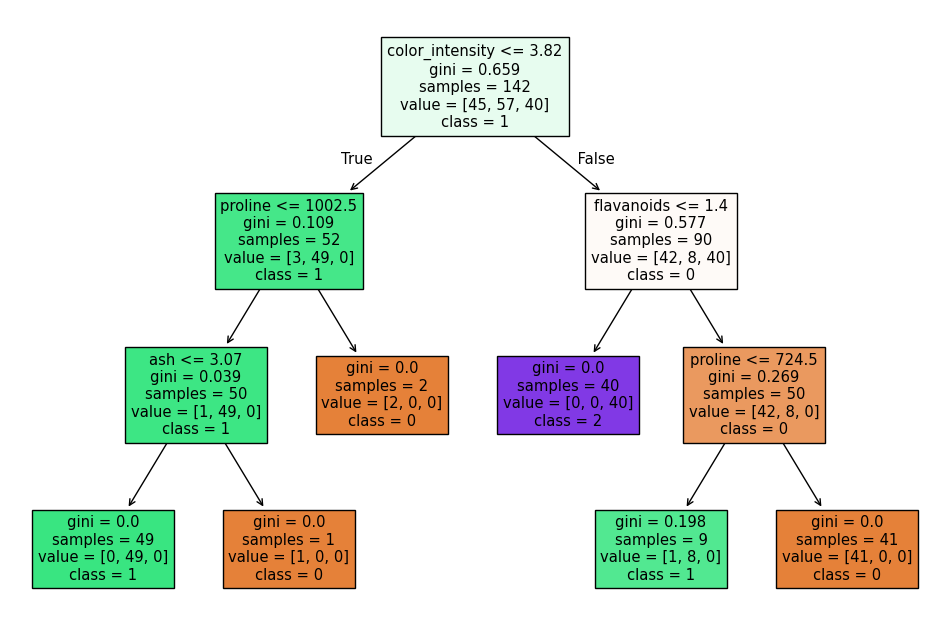

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

wine_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wine.csv')
X = wine_df.drop(columns=['label'])
y = wine_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

para_grid = {'max_depth' : [2, 3, 4, 5, 6], 'min_samples_leaf' : [1, 5, 10]}

dt_clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt_clf, para_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_para = grid_search.best_params_
best_dt_clf = DecisionTreeClassifier(**best_para, random_state=42)
best_dt_clf.fit(X_train, y_train)

train_acc = best_dt_clf.score(X_train, y_train)
test_acc = best_dt_clf.score(X_test, y_test)

print('best parameters:', best_para)
print('training accuracy:', train_acc)
print('testing accuracy:', test_acc)

plt.figure(figsize=(12, 8))
plot_tree(best_dt_clf, filled=True, feature_names=X.columns, class_names=np.unique(y).astype(str))
plt.show()

### Now, I am writing a function that takes `tree_` as input, traverses the decision tree and converts it into a nested dictionary format.

Each internal node in the nested dictionary should contain:
- `"feature"`: Index of the feature used for the split (if not a leaf).
- `"threshold"`: Threshold value for the split (if not a leaf).
- `"left"` and `"right"`: Nested dictionaries representing the left and right children, respectively.

Each leaf node in the nested dictionary should contain:
- `"prediction"`: Predicted label

Then, I will convert the tree obtained above into a nested dictionary.


In [ ]:
def tree_to_dict(tree, node=0):
  if tree.feature[node] != -2:
    return {
        'feature': int(tree.feature[node]),
        'threshold': float(tree.threshold[node]),
        'left': tree_to_dict(tree, tree.children_left[node]),
        'right': tree_to_dict(tree, tree.children_right[node])
    }
  else:
    return {'prediction': int(np.argmax(tree.value[node]))}

tree_dict = tree_to_dict(best_dt_clf.tree_)
print(tree_dict)

{'feature': 9, 'threshold': 3.819999933242798, 'left': {'feature': 12, 'threshold': 1002.5, 'left': {'feature': 2, 'threshold': 3.0700000524520874, 'left': {'prediction': 1}, 'right': {'prediction': 0}}, 'right': {'prediction': 0}}, 'right': {'feature': 6, 'threshold': 1.399999976158142, 'left': {'prediction': 2}, 'right': {'feature': 12, 'threshold': 724.5, 'left': {'prediction': 1}, 'right': {'prediction': 0}}}}


## K-Means Clustering

### Here, I implement the K-Means algorithm using Euclidean distance from scratch where `class` takes the following arguments:
- the number of clusters `K`,
- the maximum number of iterations `max_iter`,
- the tolerance of the mean distance from the sample to their closest cluster differences between two iterations `tol`.

After implementing the K-Means algorithm, I explored the `mall_customer.csv` data loaded with the following code:
```python
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("mall_customers.csv").values
scalar = MinMaxScaler()
data = scalar.fit_transform(data)
plt.scatter(data[:,0],data[:,1])
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()
```

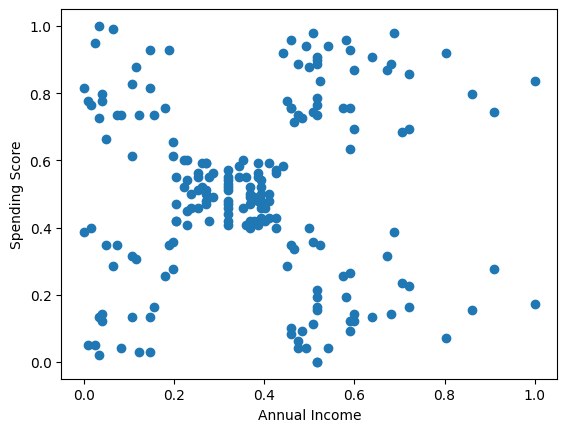

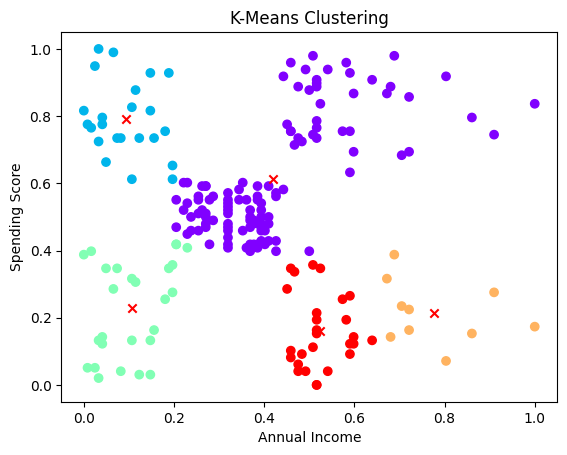

In [ ]:
class Kmean:
  def __init__(self, K, max_iter=100, tol=1e-4):
    self.K = K
    self.max_iter = max_iter
    self.tol = tol

  def fit(self, X):
    np.random.seed(42)
    self.centers =X[np.random.choice(X.shape[0], self.K, replace=False)]

    for i in range(self.max_iter):
      distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
      labels = np.argmin(distances, axis=1)

      new_centers = np.array([X[labels == k].mean(axis=0) for k in range(self.K)])

      if np.linalg.norm(self.centers - new_centers) < self.tol:
        break
      self.centers = new_centers

    self.labels = labels

  def predict(self, X):
    distances = np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2)
    return np.argmin(distances, axis=1)


from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mall_customers.csv').values
scalar = MinMaxScaler()
data = scalar.fit_transform(data)
plt.scatter(data[:,0],data[:,1])
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

kmeans = Kmean(K=5)
kmeans.fit(data)
labels = kmeans.labels

plt.scatter(data[:,0],data[:,1], c=labels, cmap='rainbow')
plt.scatter(kmeans.centers[:,0],kmeans.centers[:,1], c='red', marker='x')
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title('K-Means Clustering')
plt.show()


### Next, I set up $K$ from 1 to 10, and plotted the average distance between the cluster centroids and the assigned samples in the dataset. Based on this plot, I determined an appropriate value of $K$ for this dataset.


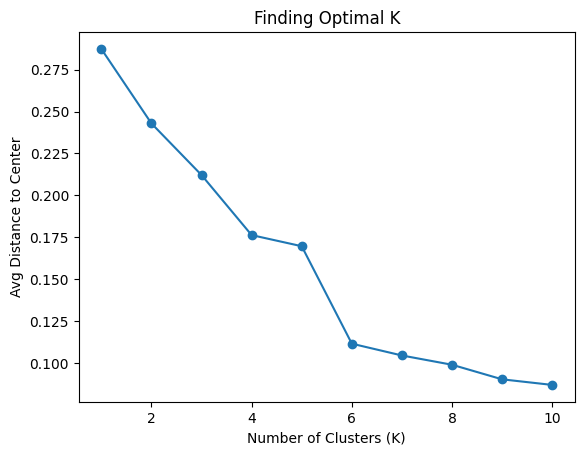

In [ ]:
avg_distances = []
K_range = range(1,11)
for K in K_range:
  kmeans = Kmean(K=K)
  kmeans.fit(data)
  distances = np.linalg.norm(data - kmeans.centers[kmeans.labels], axis=1)
  avg_distances.append(np.mean(distances))

plt.plot(K_range, avg_distances, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Avg Distance to Center")
plt.title('Finding Optimal K')
plt.show()

### Then, I used the $K$ I previously selected to train my K-Means model. Then, I created a scatter plot of the dataset, using different colors to represent different clusters, and marked the center of each cluster. I explained  what types of customers each cluster represents.


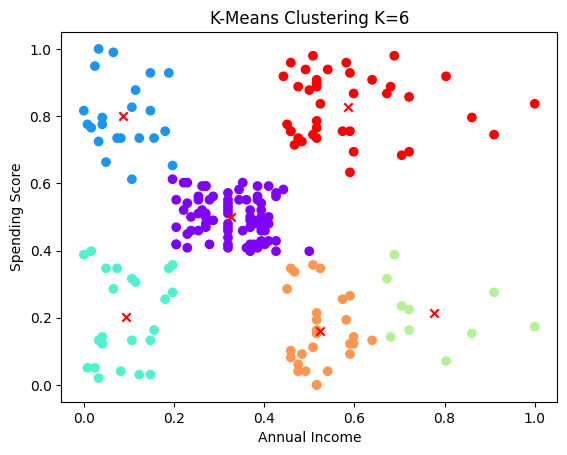

In [ ]:
k_optimal = 6
kmeans = Kmean(K=k_optimal)
kmeans.fit(data)
labels = kmeans.labels

plt.scatter(data[:,0],data[:,1], c=labels, cmap='rainbow')
plt.scatter(kmeans.centers[:,0],kmeans.centers[:,1], c='red', marker='x')
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title(f'K-Means Clustering K={k_optimal}')
plt.show()

The dark blue cluster (low income, high spending) are impulse buyers

The light blue cluster (low income, low spending) are careful spenders

The purple cluster (avg income, avg spending) are normal buyers

The orange and gree clusters (higher income, low spending) are careful spenders

The red cluster (high income, high spending) are luxury buyers




## Random forest.

Here, I explored the controversial analysis by the ProPublica news organization (Julia Angwin, Jeff Larson, Surya Mattu, and Lauren Kirchner. Machine bias. https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing, 2016). Their argument was that the COMPAS model used throughout the US court system predicted whether someone would be arrested depended on their race, given age and criminal history.

### I trained a random forest on the ProPublica dataset to predict recidivism and to predict whether someone is arrested within 2 years based on their age, criminal history, and race. I split the dataset into training and test sets using an 80/20 split.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

propublica_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProPublica_COMPAS_preprocessed.csv')

features = ["p_current_age", "p_age_first_offense", "p_charge", "p_jail30",
    "p_prison", "p_probation", "race_black", "race_white",
    "race_hispanic", "race_asian", "race_native"]

label = "recid_use(label)"

X = propublica_df[features]
y = propublica_df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test Accuracy: {test_acc: 4f}')
print(f'F1 Score: {f1: 4f}')

Test Accuracy:  0.643979
F1 Score:  0.448649


### Then, I measured the variable importance of the random forest I just trained for the race variable.

In [ ]:
importance = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                Feature  Importance
2              p_charge    0.284054
0         p_current_age    0.280051
1   p_age_first_offense    0.264029
5           p_probation    0.072696
4              p_prison    0.036364
6            race_black    0.019037
7            race_white    0.017481
8         race_hispanic    0.011344
3              p_jail30    0.011235
9            race_asian    0.002218
10          race_native    0.001490


The model relies more on criminal history and age-related variables. However, race appears to still have some influence and this might indicate potential bias in the dataset or the way features interact.

### I removed the two features with the highest variable importance

In [ ]:
features_reduced = ["p_age_first_offense", "p_jail30",
    "p_prison", "p_probation", "race_black", "race_white",
    "race_hispanic", "race_asian", "race_native"]

X_reduced = propublica_df[features_reduced]

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)


rf_red = RandomForestClassifier(n_estimators=100, random_state=42)
rf_red.fit(X_train_red, y_train_red)

importance_red = rf_red.feature_importances_

feature_importance_red_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': importance_red
})

feature_importance_red_df = feature_importance_red_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances Reduced:")
print(feature_importance_red_df)



Feature Importances Reduced:
               Feature  Importance
0  p_age_first_offense    0.599566
3          p_probation    0.179287
2             p_prison    0.110179
4           race_black    0.034844
1             p_jail30    0.031369
5           race_white    0.024781
6        race_hispanic    0.012604
7           race_asian    0.004689
8          race_native    0.002681


Race is more important than before as race_black increased by 1.6% and race_white increased by 1.8%. Other races also increased slightly.

### Then I trained a logistic regression model on the original dataset.


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

test_acc_log = accuracy_score(y_test, y_pred_log)

coeff = log_reg.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coeff
})


coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(f'Test Accuracy Log Reg: {test_acc_log:4f}')
print('\nFeature Coefficients (Log Reg):')
print(coef_df)

Test Accuracy Log Reg: 0.670157

Feature Coefficients (Log Reg):
                Feature  Coefficient
6            race_black     0.191780
5           p_probation     0.090013
2              p_charge     0.050846
7            race_white     0.003045
1   p_age_first_offense    -0.014023
4              p_prison    -0.014975
0         p_current_age    -0.029843
8         race_hispanic    -0.157661
3              p_jail30    -0.286888
10          race_native    -0.335272
9            race_asian    -0.547084


Logisitic Regression performed slightly better than the Random Forest in terms of accuracy.

Race_black has the largest positive impact on recidivism in logistic regression, aligning with its importance in Random Forest. Race_white is nearly neutral in logistic regression, suggesting little predictive value. The other races have negative coefficients, meaning these groups are less likely to recidivate relative to the reference category.

Logistic Regression suggests race has a slightly stronger effect than Random Forest. Age and criminal history remain the strongest predictors in both models.

### My Take:

 I agree that race has an effect even though my analysis does not show that it is the primary driver of predictions. The model uses variables such as prior charges\history of incarceration and age at first offense. These features reflect structural inequalities present in society that arent necessarily explicit in the model but still perpetuated in the data.

ProPublica went wrong by focusing on racial bias as a standalone issue, rather than recognizing that racial disparities can be a reflection of structural inequalities within the justice system itself. It's possible that the model is simply mirroring disparities that already exist.